In [2]:
import numpy as np
import xarray as xr    
import glob
import pandas as pd
import itertools
import sklearn
import os
import sys

In [3]:
def load_geom_files(filepath_geomvars, filepath_mask, join_ice_shelves = False):
    geoms = xr.open_dataset(filepath_geomvars)
    masks = xr.open_dataset(filepath_mask)
    print('You have loaded:', filepath_geomvars)
    print('You have loaded:', filepath_mask)
    bN_00 = masks.basins_NEMO
    # Some ice shelves which should potentially be joined together into one bigger ice shelf
    if join_ice_shelves == True:
        # Dotson and Crosson?
        #basins_NEMO[basins_NEMO == 101] = 129
        # Abbot Ice Shelf
        bN_01 = xr.where(bN_00 == 109, 143, bN_00)
        # George VI
        bN_02 = xr.where(bN_01 == 112, 125, bN_01)
        # Lambert 
        basins_merged = xr.where(bN_02 == 20, 103, bN_02)
        print('Ice shelves joined, as requested')
    else:
        basins_merged = bN_00    
    return masks, basins_merged, geoms

# Create a function to read in the simulation runs and convert them to pd dataframes
def create_df_total(nemo_run, year, month, verbose = 0):
    ''' This function reads in a .nc xarray file, and adds in the mean and std of T and S '''
    ''' and the slope parameters, and then saves these as a pandas dataframe to be merged '''
    ''' Verbose = 0, 1, >1                                                                '''
    filepath_ij = filepath_nn_input + nemo_run + '_y' + year + '.nc'
    if verbose == 1:
        print('You have loaded:', filepath_ij)
    data = xr.open_dataset(filepath_ij)
    if data.dims['y'] > 439:
        min_lat = -52.2
        y_trim = np.max(np.argwhere(data.lat[:,0].data <= min_lat))
        # Take this slice 
        data = data.sel(y = slice(0,y_trim+1))
        data = data.sel(x = slice(1,1441))
    mean_T = np.ones(basins_merged.shape)*np.nan
    mean_S = np.ones(basins_merged.shape)*np.nan
    std_T = np.ones(basins_merged.shape)*np.nan
    std_S = np.ones(basins_merged.shape)*np.nan
    for j in basin_nos:
        mask_basin = basins_merged*masks.closed_cavities_nan == j
        if np.sum(np.isnan(data.temperature_prop.data[mask_basin])) == 0:
            mean_T[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanmean(data.temperature_prop.data[mask_basin])
            mean_S[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanmean(data.salinity_prop.data[mask_basin])
            std_T[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanstd(data.temperature_prop.data[mask_basin])
            std_S[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanstd(data.salinity_prop.data[mask_basin])
        else:
            if verbose > 1:
                print(np.sum(np.isnan(data.temperature_prop.data[mask_basin])), 'nan cells in basin', j)
            if np.sum(~np.isnan(data.temperature_prop.data[mask_basin])) > 0:
                mean_T[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanmean(data.temperature_prop.data[mask_basin])
                mean_S[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanmean(data.salinity_prop.data[mask_basin])
                std_T[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanstd(data.temperature_prop.data[mask_basin])
                std_S[mask_basin] = np.ones(len(data.temperature_prop.data[mask_basin])) * np.nanstd(data.salinity_prop.data[mask_basin])
    year_label = []
    month_label = []
    for i in range(len(std_S[masks.closed_cavities == 1])):
        year_label.append(year)
        month_label.append(month)
    # Because Christoph's simulations report melting as positive and refreezing as negative, flip these simulations
    if nemo_run in ('ctrl94', 'isf94', 'isfru94'):
        flip_melt = -1
    else:
        flip_melt = 1
    df_total = pd.DataFrame({
                            'lat': data.lat.data[masks.closed_cavities == 1], 
                            'lon': data.lon.data[masks.closed_cavities == 1], 
                            'temperature_prop': data.temperature_prop.data[masks.closed_cavities == 1],
                            'salinity_prop': data.salinity_prop.data[masks.closed_cavities ==1],
                            'melt_m_ice_per_y': data.melt_ice_per_yr.data[masks.closed_cavities == 1] * flip_melt,
                            'mean_T': mean_T[masks.closed_cavities == 1],
                            'mean_S': mean_S[masks.closed_cavities == 1],
                            'std_T': std_T[masks.closed_cavities == 1],
                            'std_S': std_S[masks.closed_cavities == 1], 
                            'year': year_label, 
                            'month': month_label, 
                            'basins_NEMO': basins_merged.data[masks.closed_cavities == 1],
                            'distances_GL': geoms.distances_GL.data[masks.closed_cavities == 1],
                            'distances_OO': geoms.distances_OO.data[masks.closed_cavities == 1],
                            'distances_OC': geoms.distances_OC.data[masks.closed_cavities == 1],
                            'corrected_isdraft': geoms.isf_draft.data[masks.closed_cavities ==1],
                            'area': geoms.areas.data[masks.closed_cavities == 1],
                            'bathymetry': geoms.bathymetry.data[masks.closed_cavities == 1],
                            'slope_is_lon': geoms.slope_isdraft_lon.data[masks.closed_cavities == 1],
                            'slope_is_lat': geoms.slope_isdraft_lat.data[masks.closed_cavities == 1],
                            'slope_ba_lon': geoms.slope_bathy_lon.data[masks.closed_cavities == 1],
                            'slope_ba_lat': geoms.slope_bathy_lat.data[masks.closed_cavities == 1],
                            'slope_is_across_front': geoms.slope_is_across_front.data[masks.closed_cavities == 1],
                            'slope_is_towards_front': geoms.slope_is_towards_front.data[masks.closed_cavities == 1],
                            'slope_ba_across_front': geoms.slope_ba_across_front.data[masks.closed_cavities == 1],
                            'slope_ba_towards_front': geoms.slope_ba_towards_front.data[masks.closed_cavities == 1],
                            })
    if verbose > 1:
        print(np.sum(np.isnan(df_total['temperature_prop'])), 'nan values removed')
    df_total2 = df_total[~np.isnan(df_total['temperature_prop'])]
    return df_total2

In [4]:
# Set the nemo_run
nemo_run = str(sys.argv[1])
nemo_run = 'OPM016'
print('Nemo run:', nemo_run)

Nemo run: OPM016


In [5]:
filepath_base = '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/'
filepath_nn_input = filepath_base + "data/processing_ho/nn_input_"

# Set where you would like to save the data 
data_out_fp = '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Training_data/'
# Create a dataframe with all the data which is saved in this location
intermediate_filepath = data_out_fp + nemo_run + '_' + 'whole_dataset' + '_' + 'not_yet_normalised.csv'

In [6]:
# Check which simulation datasets are available to look at 
processed_files = glob.glob(filepath_nn_input + nemo_run + '*y*.nc')
print('There are', len(processed_files), 'datasets available')

There are 29 datasets available


In [7]:
processed_files

['/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y2006.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1990.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1984.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1992.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y2002.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1986.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1994.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1993.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1996.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_input_OPM016_y1981.nc',
 '/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/data/processing_ho/nn_i

In [8]:
years_run = []
for i in range(len(processed_files)):
    year = (processed_files[i].split(os.path.sep)[-1].split('_')[-1].split('.')[0].split('y')[-1])
    years_run.append(year)
years_run.sort()
print(years_run)
print(len(years_run), 'files processed') 

['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008']
29 files processed


In [9]:
# Load in the closed_cavitites mask, and the slopes 
filepath_mask = filepath_base +  'AIAI_data/Masks/'+nemo_run+'_'+'geometric_masks.nc'
# A geometry file with the required variables for the NN 
filepath_geomvars = filepath_base + 'AIAI_data/Masks/'+nemo_run+'_'+'geom_vars.nc'
masks, basins_merged, geoms = load_geom_files(filepath_geomvars, filepath_mask, join_ice_shelves = True)

basin_nos_temp = np.unique(basins_merged)
count = np.zeros(len(basin_nos_temp))
for i in range(len(basin_nos_temp)):
    count[i] = np.sum((basins_merged*masks.closed_cavities_nan) == basin_nos_temp[i])
mask_keep_nos = count != 0
basin_nos = basin_nos_temp[mask_keep_nos]

You have loaded: /bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/OPM016_geom_vars.nc
You have loaded: /bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/OPM016_geometric_masks.nc
Ice shelves joined, as requested


In [10]:
print('You will save output to:')
print(intermediate_filepath)

You will save output to:
/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Training_data/OPM016_whole_dataset_not_yet_normalised.csv


In [11]:
merge = True
if merge == True:
    years_to_merge = years_run
    for i in range(len(years_to_merge)):
        if i == 0:
            year = years_run[0]
            df_total = create_df_total(nemo_run, year, month = np.nan)
        else:
            year = years_run[i]
            df_ij = create_df_total(nemo_run, year, month = np.nan)
            df_total2 = pd.concat([df_total, df_ij], ignore_index=True)
            df_total = df_total2
        print(i+1, 'out of', len(years_to_merge), 'processed', end = '\r')   
    
    intermediate_save = True
    if intermediate_save == True:
        df_total.to_csv(intermediate_filepath, index = False)
        print('You have saved:                  ')
        print(intermediate_filepath)

You have saved:                  
/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Training_data/OPM016_whole_dataset_not_yet_normalised.csv


In [12]:
df = pd.read_csv(intermediate_filepath, nrows = 5)

In [13]:
df

,lat,lon,temperature_prop,salinity_prop,melt_m_ice_per_y,mean_T,mean_S,std_T,std_S,year,...,area,bathymetry,slope_is_lon,slope_is_lat,slope_ba_lon,slope_ba_lat,slope_is_across_front,slope_is_towards_front,slope_ba_across_front,slope_ba_towards_front
0,-85.396736,-152.77846,-2.286313,34.661682,-2.101623e-06,-2.288233,34.652754,0.016509,0.024279,1980,...,1.690724e+07,1016.045532,-0.002668,0.000000,0.005232,0.000000,-0.002246,0.001441,0.004404,-0.002826
1,-85.368385,-154.12903,-2.286313,34.661682,1.022691e-06,-2.288233,34.652754,0.016509,0.024279,1980,...,1.702015e+07,936.733459,0.000000,0.014019,0.008542,0.013076,0.007571,0.011799,0.014251,0.006392
2,-85.365005,-153.69621,-2.286313,34.661682,-4.602770e-06,-2.288233,34.652754,0.016509,0.024279,1980,...,1.700046e+07,1038.535767,-0.002427,0.014427,-0.000525,0.019728,0.005748,0.013453,0.010211,0.016887
3,-85.361430,-153.26420,-2.286313,34.661682,-4.521903e-06,-2.288233,34.652754,0.016509,0.024279,1980,...,1.698055e+07,1090.237427,-0.002786,-0.005718,-0.003756,0.002972,-0.005432,-0.003308,-0.001556,0.004530
4,-85.357635,-152.83304,-2.286313,34.661682,-9.424575e-07,-2.288233,34.652754,0.016509,0.024279,1980,...,1.696043e+07,1061.649902,0.000000,-0.006122,0.002730,-0.013073,-0.003306,-0.005152,-0.004763,-0.012477


In [14]:
df = pd.read_csv(intermediate_filepath)

(array([5.0000e+00, 1.0000e+01, 2.0000e+00, 5.0000e+00, 1.0000e+01,
        1.0000e+01, 2.1000e+01, 4.3000e+01, 5.7000e+01, 8.4000e+01,
        9.9000e+01, 2.2200e+02, 3.3000e+02, 3.7900e+02, 5.6600e+02,
        8.4600e+02, 1.5050e+03, 3.7600e+03, 1.0007e+04, 1.3948e+04,
        1.0502e+04, 1.1141e+04, 1.0117e+04, 1.0742e+04, 1.1967e+04,
        1.2526e+04, 1.3990e+04, 1.6894e+04, 2.3476e+04, 2.6878e+04,
        2.4969e+04, 2.7040e+04, 2.5507e+04, 2.4073e+04, 1.7134e+04,
        1.6673e+04, 8.7430e+03, 3.0030e+03, 1.1060e+03, 4.1200e+02]),
 array([32.81495667, 32.86458836, 32.91422005, 32.96385174, 33.01348343,
        33.06311512, 33.11274681, 33.1623785 , 33.21201019, 33.26164188,
        33.31127357, 33.36090527, 33.41053696, 33.46016865, 33.50980034,
        33.55943203, 33.60906372, 33.65869541, 33.7083271 , 33.75795879,
        33.80759048, 33.85722218, 33.90685387, 33.95648556, 34.00611725,
        34.05574894, 34.10538063, 34.15501232, 34.20464401, 34.2542757 ,
        34.30390

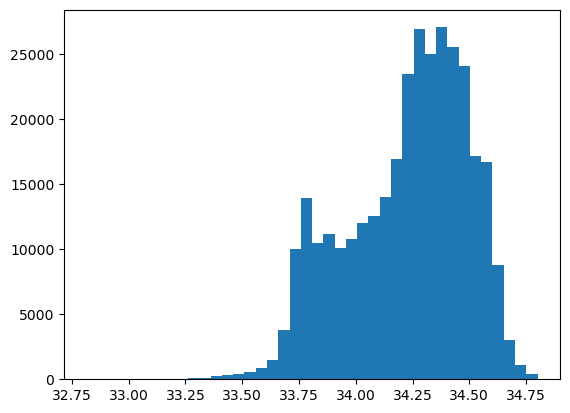

In [15]:
import matplotlib.pyplot as plt
plt.hist(df.salinity_prop, bins = 40)